# Training from merged origin
Here documents obtained with retrieval and bm25 two document origins are merged into a single dictionary of question-documents in the original bioASQ format:
- BM25 generated from original training documents.
- BM25 generated from elastic documents extracted for training questions.

**Notice that centroid is not calculated.**
## Imports

In [4]:
%load_ext autoreload
%autoreload 2

import logging
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

from src.cemb_bm25 import centroid_retrieval
from src.elastic_search_utils.elastic_utils import load_json, save_json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Params

In [5]:
LOADING_ORIGINAL_DOCUMENTS_PATH = '/datasets/johan_tests_original_format/training_docs_10b.json'
LOADING_QUERIED_DOCUMENTS_PATH = '/datasets/johan_tests_original_format/queried_docs_10b.json'

## Saving directions

In [28]:
SAVING_FOLDER = '/datasets/johan_tests_original_format/merged_training_docs'

SAVING_ABSTRACT_W2V_PATH = f'{SAVING_FOLDER}/Bio_Word2Vec_doc_abstract_model_10b_train.bin'
SAVING_TITLE_W2V_PATH = f'{SAVING_FOLDER}/Bio_Word2Vec_doc_title_model_10b_train.bin'
SAVING_QUESTION_W2V_PATH = f'{SAVING_FOLDER}/Bio_Word2Vec_doc_question_model_10b_train.bin'

SAVING_ORIGINAL_PATH = f'{SAVING_FOLDER}/training_original_10b.json'
SAVING_TOKENS_PATH = f'{SAVING_FOLDER}/training_tokens_10b.json'
SAVING_ENTITY_PATH = f'{SAVING_FOLDER}/training_entity_10b.json'

## Constants

In [7]:
original_questions = load_json(LOADING_ORIGINAL_DOCUMENTS_PATH)

In [8]:
queried_questions = load_json(LOADING_QUERIED_DOCUMENTS_PATH)

## Merging origins into single dictionary

In [9]:
merged_questions = centroid_retrieval.merge_origins(
    original_questions['questions'],
    queried_questions['questions']
)

merging dictionaries: 4234it [00:03, 1115.02it/s]


## Extracting unique document info
Only documents with abstract will be kept.

One dict cleaned-tokenized, another only cleaned.

In [10]:
unique_docs = centroid_retrieval.extract_unique_doc_info(
    questions=merged_questions['questions']
)

Extracting unique doc info: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4234/4234 [00:00<00:00, 36072.38it/s]


## Extracting tokens for valid documents

In [11]:
tokenized_unique_docs = centroid_retrieval.docs_to_tokens(
    unique_docs=unique_docs,
    n_jobs=16,
    verbose=1
)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.2s
[Parallel(n_jobs=16)]: Done 356 tasks      | elapsed:    5.4s
[Parallel(n_jobs=16)]: Done 12448 tasks      | elapsed:    7.5s
[Parallel(n_jobs=16)]: Done 34848 tasks      | elapsed:   11.1s
[Parallel(n_jobs=16)]: Done 63648 tasks      | elapsed:   15.8s
[Parallel(n_jobs=16)]: Done 98848 tasks      | elapsed:   22.4s
[Parallel(n_jobs=16)]: Done 140448 tasks      | elapsed:   29.3s
[Parallel(n_jobs=16)]: Done 188448 tasks      | elapsed:   37.0s
[Parallel(n_jobs=16)]: Done 242848 tasks      | elapsed:   47.0s
[Parallel(n_jobs=16)]: Done 303648 tasks      | elapsed:   57.1s
[Parallel(n_jobs=16)]: Done 324189 out of 324189 | elapsed:  1.0min finished


## Extracting entities for valid documents

In [12]:
entitized_unique_docs = centroid_retrieval.docs_to_entities(
    unique_docs=unique_docs,
    n_jobs=16,
    verbose=1
)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 304 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 804 tasks      | elapsed:    8.2s
[Parallel(n_jobs=16)]: Done 1504 tasks      | elapsed:   14.4s
[Parallel(n_jobs=16)]: Done 2404 tasks      | elapsed:   22.4s
[Parallel(n_jobs=16)]: Done 3504 tasks      | elapsed:   32.4s
[Parallel(n_jobs=16)]: Done 4804 tasks      | elapsed:   45.7s
[Parallel(n_jobs=16)]: Done 6304 tasks      | elapsed:   59.4s
[Parallel(n_jobs=16)]: Done 8004 tasks      | elapsed:  1.3min
[Parallel(n_jobs=16)]: Done 9904 tasks      | elapsed:  1.5min
[Parallel(n_jobs=16)]: Done 12004 tasks      | elapsed:  1.8min
[Parallel(n_jobs=16)]: Done 14304 tasks      | elapsed:  2.2min
[Parallel(n_jobs=16)]: Done 16804 tasks      | elapsed:  2.6min
[Parallel(n_jobs=16)]: Done 19504 tasks      | elapsed:  3.0min
[Parallel(n_jobs=16)]: Done 22404 tasks 

## Tokenize question body and replace documents with tokenized documents

In [13]:
tokenized_questions, question_solving_doc_ids = centroid_retrieval.select_questions_useful_documents(
    questions=merged_questions['questions'],
    unique_docs=tokenized_unique_docs
)

Selecting useful documents: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4234/4234 [00:24<00:00, 173.19it/s]


In [14]:
tokenized_questions = {'questions': tokenized_questions}

## (Graph entity dict) Tokenize question body and replace documents with entity extracted documents

In [15]:
graph_questions, question_solving_doc_ids = centroid_retrieval.select_questions_useful_documents(
    questions=merged_questions['questions'],
    unique_docs=entitized_unique_docs
)

Selecting useful documents: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4234/4234 [00:24<00:00, 171.72it/s]


In [16]:
graph_questions = {'questions': graph_questions}

## Extracting unique tokenized abstracts and titles for word2vec

In [18]:
unique_abstract_tokens, unique_title_tokens = centroid_retrieval.extract_unique_titles_and_abstracts(
    tokenized_unique_docs=tokenized_unique_docs,
    question_solving_doc_ids=question_solving_doc_ids
)

In [19]:
len(unique_abstract_tokens), len(unique_title_tokens)

(324189, 324189)

In [20]:
len(list(unique_abstract_tokens.values())[0]), len(list(unique_title_tokens.values())[0])

(152, 11)

## Extracting unique tokenized questions for word2vec

In [21]:
unique_question_tokens = centroid_retrieval.extract_unique_questions(
    tokenized_questions['questions']
)

In [22]:
len(unique_question_tokens)

4234

In [23]:
len(list(unique_question_tokens.values())[0])

9

## Making fit models w2vec models for questions, titles and abstracts

In [24]:
question_w2vec_model, question_w2vec_vocab = centroid_retrieval.fit_bio_w2vec(unique_question_tokens.values())

Word2Vec vocabulary length: 6669


In [25]:
abstract_w2vec_model, abstract_w2vec_vocab = centroid_retrieval.fit_bio_w2vec(unique_abstract_tokens.values())

Word2Vec vocabulary length: 516803


In [26]:
title_w2vec_model, title_w2vec_vocab = centroid_retrieval.fit_bio_w2vec(unique_title_tokens.values())

Word2Vec vocabulary length: 135713


## Saving models into disk

In [30]:
question_w2vec_model.save(SAVING_QUESTION_W2V_PATH)

In [31]:
abstract_w2vec_model.save(SAVING_ABSTRACT_W2V_PATH)

In [32]:
title_w2vec_model.save(SAVING_TITLE_W2V_PATH)

## Sorting scores in descending fashion
### Making question_scores artificial dict

In [34]:
question_scores = {
    question['id']: {
        doc['id']: doc['score']
        for doc in question['documents']
    }
    for question in tokenized_questions['questions']
}

### Original dict (for Andres model)

In [37]:
centroid_retrieval.update_question_scores_from_raw_data(
    raw_questions=merged_questions['questions'],
    question_scores=question_scores
)

Updating dictionary with centroid scores: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4234/4234 [00:00<00:00, 15905.86it/s]


### Tokenized dict

In [38]:
centroid_retrieval.update_question_scores(
    raw_questions=tokenized_questions['questions'],
    question_scores=question_scores
)

Updating dictionary with centroid scores: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4234/4234 [00:00<00:00, 21906.05it/s]


### Graph dict (only tokens and entities)

In [39]:
centroid_retrieval.update_question_scores(
    raw_questions=graph_questions['questions'],
    question_scores=question_scores
)

Updating dictionary with centroid scores: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4234/4234 [00:00<00:00, 16239.21it/s]


## Saving into disk

In [41]:
save_json(merged_questions, SAVING_ORIGINAL_PATH)

In [42]:
save_json(tokenized_questions, SAVING_TOKENS_PATH)

In [43]:
save_json(graph_questions, SAVING_ENTITY_PATH)

## Plotting distribution of number of documents

In [44]:
len_docs = [len(question['documents']) for question in merged_questions['questions']]

<AxesSubplot:>

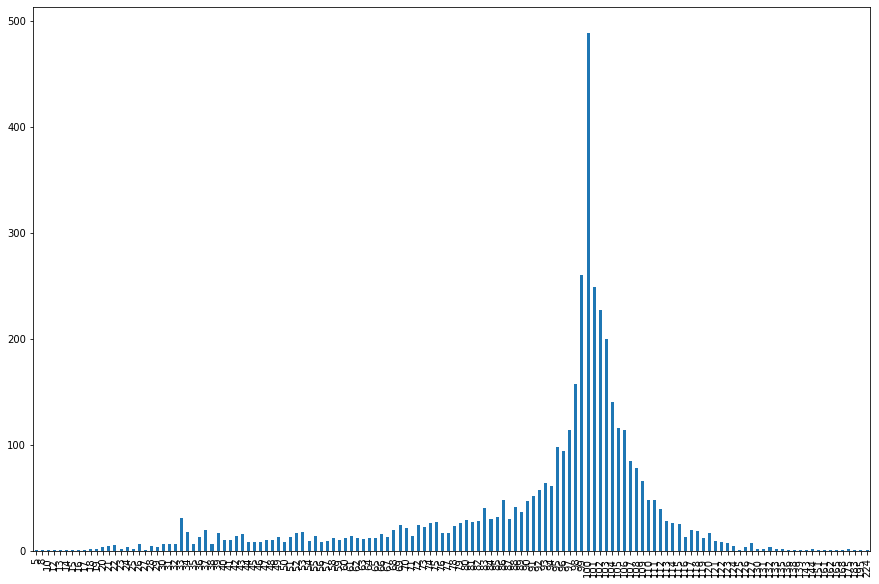

In [45]:
pd.value_counts(len_docs).sort_index().plot(kind='bar', figsize=(15,10))

In [46]:
graph_questions['questions'][0]

{'body': ['is',
  'hirschsprung',
  'disease',
  'a',
  'mendelian',
  'or',
  'a',
  'multifactorial',
  'disorder'],
 'ideal_answer': ["Coding sequence mutations in RET, GDNF, EDNRB, EDN3, and SOX10 are involved in the development of Hirschsprung disease. The majority of these genes was shown to be related to Mendelian syndromic forms of Hirschsprung's disease, whereas the non-Mendelian inheritance of sporadic non-syndromic Hirschsprung disease proved to be complex; involvement of multiple loci was demonstrated in a multiplicative model."],
 'concepts': ['http://www.disease-ontology.org/api/metadata/DOID:10487',
  'http://www.nlm.nih.gov/cgi/mesh/2015/MB_cgi?field=uid&exact=Find+Exact+Term&term=D006627',
  'http://www.nlm.nih.gov/cgi/mesh/2015/MB_cgi?field=uid&exact=Find+Exact+Term&term=D020412',
  'http://www.disease-ontology.org/api/metadata/DOID:11372'],
 'type': 'summary',
 'id': '55031181e9bde69634000014',
 'snippets': [{'offsetInBeginSection': 131,
   'offsetInEndSection': 358,